In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer


np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df_train = df.copy()

df_train.iloc[0]

listing_id                                                                                     122881
title                                                       hdb flat for sale in 866 yishun street 81
address                                                                      sembawang / yishun (d27)
property_name                                                                    866 yishun street 81
property_type                                                                             hdb 4 rooms
tenure                                                                                            NaN
built_year                                                                                     1988.0
num_beds                                                                                          3.0
num_baths                                                                                         2.0
size_sqft                                                                         

In [5]:
# Utility functions

def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

# Constants
initial_drop_columns = [
        'address',
        'title',
        'listing_id',
        'property_name',
        'available_unit_types',
        'property_details_url',
        'elevation',
        'tenure',
        'property_type',
        'floor_level',
        'furnishing',
        'subzone',
        'lat',
        'lng',
        'area_size',
        'population',
    ]

In [6]:
df_train = preprocess(df_train)
df_train = prepare_data_for_regression(df_train, drop_columns=initial_drop_columns)
df_train.head()

,built_year,num_beds,num_baths,size_sqft,total_num_units,planning_area,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,floor_level_ground,floor_level_high,floor_level_low,floor_level_mid,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,line_dt,line_ew,line_ne,line_ns,line_te,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,gep_pri_sch_within_1km,gep_pri_sch_within_1km_2km,gep_pri_sch_outside_2km,pri_sch_within_500m,pri_sch_outside_500m,nearest_com_centre_distance_in_km,cc_type_BN,cc_type_CR,cc_type_IEBP,cc_type_IHL,nearest_mall_distance_in_km,density,region
0,1988.0,3.0,2.0,1115.0,116.0,yishun,514500.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.574204,0,0,0,0,0,0,1,0,0.275582,6.194099,0,0,1,1,0,3.338999,0,1,0,0,0.621334,31517.683928,n
1,1992.0,4.0,2.0,1575.0,NaN,serangoon,995400.0,0,1,0,1,0,0,0,0,0,0,0,0,1,1.734303,0,0,0,0,0,1,0,0,0.122925,0.122925,1,0,0,1,0,2.401882,1,0,0,0,0.552544,23280.268731,ne
2,2022.0,4.0,6.0,3070.0,56.0,marine parade,8485000.0,1,0,1,0,0,0,1,0,0,0,1,0,0,1.319766,1,0,0,0,0,0,0,0,0.891475,1.872702,0,1,0,0,1,2.171328,1,0,0,0,0.824208,5829.779777,c
3,2023.0,3.0,2.0,958.0,638.0,bukit timah,2626000.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.726006,1,0,0,0,0,0,0,0,1.090371,1.090371,0,1,0,0,1,1.605928,1,0,0,0,0.907063,11059.413028,c
4,2026.0,2.0,1.0,732.0,351.0,downtown core,1764000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.371115,0,0,0,0,1,0,0,0,0.464835,2.742534,0,0,1,1,0,1.869574,0,1,0,0,0.430415,775.193798,c


In [7]:
X_train = df_train.drop('price', axis=1)
y_train = df_train['price']

In [8]:
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "planning_area"]),
    remainder='passthrough')

def ttr(pipeline):
    return TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

def transform_data(df):
    p = make_pipeline(ct, StandardScaler(), KNNImputer())
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df), columns=p.get_feature_names_out())

In [9]:
transformed_X = transform_data(X_train)
transformed_X.head()

,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__planning_area_ang mo kio,onehotencoder__planning_area_bedok,onehotencoder__planning_area_bishan,onehotencoder__planning_area_bukit batok,onehotencoder__planning_area_bukit merah,onehotencoder__planning_area_bukit panjang,onehotencoder__planning_area_bukit timah,onehotencoder__planning_area_central water catchment,onehotencoder__planning_area_changi,onehotencoder__planning_area_choa chu kang,onehotencoder__planning_area_clementi,onehotencoder__planning_area_downtown core,onehotencoder__planning_area_geylang,onehotencoder__planning_area_hougang,onehotencoder__planning_area_jurong east,onehotencoder__planning_area_jurong west,onehotencoder__planning_area_kallang,onehotencoder__planning_area_lim chu kang,onehotencoder__planning_area_mandai,onehotencoder__planning_area_marine parade,...,remainder__furnishing_unfurnished,remainder__furnishing_unspecified,remainder__nearest_mrt_distance_in_km,remainder__line_cc,remainder__line_ce,remainder__line_cg,remainder__line_dt,remainder__line_ew,remainder__line_ne,remainder__line_ns,remainder__line_te,remainder__nearest_pri_sch_distance_in_km,remainder__nearest_gep_pri_sch_distance_in_km,remainder__gep_pri_sch_within_1km,remainder__gep_pri_sch_within_1km_2km,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__nearest_com_centre_distance_in_km,remainder__cc_type_BN,remainder__cc_type_CR,remainder__cc_type_IEBP,remainder__cc_type_IHL,remainder__nearest_mall_distance_in_km,remainder__density
0,-1.022339,-0.327651,2.956568,-0.454825,-0.365672,-0.193907,-0.21663,-0.113452,-0.17095,-0.17521,-0.1244,-0.263618,-0.063143,-0.048871,-0.137725,-0.165648,-0.205990,-0.151157,-0.178789,-0.08603,-0.143777,-0.206252,-0.019932,-0.009964,-0.207166,...,-0.332735,0.614818,-0.387375,-0.524097,-0.052798,-0.039887,-0.546662,-0.514928,-0.476923,1.622855,-0.211686,-0.870002,0.992342,-0.402533,-0.546126,0.764998,1.270110,-1.270110,1.332502,-0.879390,2.087855,-0.596672,-0.360066,-0.322523,1.392520
1,-1.022339,-0.327651,-0.338230,2.198649,-0.365672,-0.193907,-0.21663,-0.113452,-0.17095,-0.17521,-0.1244,-0.263618,-0.063143,-0.048871,-0.137725,-0.165648,-0.205990,-0.151157,-0.178789,-0.08603,-0.143777,-0.206252,-0.019932,-0.009964,-0.207166,...,-0.332735,0.614818,1.698473,-0.524097,-0.052798,-0.039887,-0.546662,-0.514928,2.096775,-0.616198,-0.211686,-1.154203,-1.187419,2.484269,-0.546126,-1.307193,1.270110,-1.270110,0.454867,1.137151,-0.478960,-0.596672,-0.360066,-0.451613,0.704546
2,0.978149,-0.327651,-0.338230,-0.454825,-0.365672,-0.193907,-0.21663,-0.113452,-0.17095,-0.17521,-0.1244,-0.263618,-0.063143,-0.048871,-0.137725,-0.165648,-0.205990,-0.151157,-0.178789,-0.08603,-0.143777,-0.206252,-0.019932,-0.009964,4.827045,...,-0.332735,-1.626497,0.953139,1.908045,-0.052798,-0.039887,-0.546662,-0.514928,-0.476923,-0.616198,-0.211686,0.276600,-0.559189,-0.402533,1.831080,-1.307193,-0.787333,0.787333,0.238947,1.137151,-0.478960,-0.596672,-0.360066,0.058179,-0.752887
3,0.978149,-0.327651,-0.338230,-0.454825,-0.365672,-0.193907,-0.21663,-0.113452,-0.17095,-0.17521,-0.1244,3.793364,-0.063143,-0.048871,-0.137725,-0.165648,-0.205990,-0.151157,-0.178789,-0.08603,-0.143777,-0.206252,-0.019932,-0.009964,-0.207166,...,-0.332735,-1.626497,-0.114437,1.908045,-0.052798,-0.039887,-0.546662,-0.514928,-0.476923,-0.616198,-0.211686,0.646883,-0.840072,-0.402533,1.831080,-1.307193,-0.787333,0.787333,-0.290565,1.137151,-0.478960,-0.596672,-0.360066,0.213661,-0.316117
4,0.978149,-0.327651,-0.338230,-0.454825,-0.365672,-0.193907,-0.21663,-0.113452,-0.17095,-0.17521,-0.1244,-0.263618,-0.063143,-0.048871,-0.137725,-0.165648,4.854593,-0.151157,-0.178789,-0.08603,-0.143777,-0.206252,-0.019932,-0.009964,-0.207166,...,-0.332735,0.614818,-0.752526,-0.524097,-0.052798,-0.039887,-0.546662,1.942018,-0.476923,-0.616198,-0.211686,-0.517673,-0.246889,-0.402533,-0.546126,

In [10]:
transformed_X[transformed_X.isna().any(axis=1)]

,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__planning_area_ang mo kio,onehotencoder__planning_area_bedok,onehotencoder__planning_area_bishan,onehotencoder__planning_area_bukit batok,onehotencoder__planning_area_bukit merah,onehotencoder__planning_area_bukit panjang,onehotencoder__planning_area_bukit timah,onehotencoder__planning_area_central water catchment,onehotencoder__planning_area_changi,onehotencoder__planning_area_choa chu kang,onehotencoder__planning_area_clementi,onehotencoder__planning_area_downtown core,onehotencoder__planning_area_geylang,onehotencoder__planning_area_hougang,onehotencoder__planning_area_jurong east,onehotencoder__planning_area_jurong west,onehotencoder__planning_area_kallang,onehotencoder__planning_area_lim chu kang,onehotencoder__planning_area_mandai,onehotencoder__planning_area_marine parade,...,remainder__furnishing_unfurnished,remainder__furnishing_unspecified,remainder__nearest_mrt_distance_in_km,remainder__line_cc,remainder__line_ce,remainder__line_cg,remainder__line_dt,remainder__line_ew,remainder__line_ne,remainder__line_ns,remainder__line_te,remainder__nearest_pri_sch_distance_in_km,remainder__nearest_gep_pri_sch_distance_in_km,remainder__gep_pri_sch_within_1km,remainder__gep_pri_sch_within_1km_2km,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__nearest_com_centre_distance_in_km,remainder__cc_type_BN,remainder__cc_type_CR,remainder__cc_type_IEBP,remainder__cc_type_IHL,remainder__nearest_mall_distance_in_km,remainder__density


In [11]:
# https://guhanesvar.medium.com/feature-selection-based-on-mutual-information-gain-for-classification-and-regression-d0f86ea5262a
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(transformed_X, y_train)

In [12]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = transformed_X.columns
mutual_info.sort_values(ascending=False)[0:10]

remainder__size_sqft                                    2.269525
remainder__property_type_public                         2.019704
remainder__nearest_gep_pri_sch_distance_in_km           1.990781
remainder__nearest_pri_sch_distance_in_km               1.969419
remainder__nearest_com_centre_distance_in_km            1.910972
remainder__nearest_mall_distance_in_km                  1.907936
remainder__nearest_mrt_distance_in_km                   1.902858
remainder__density                                      1.899349
remainder__property_type_private                        1.829327
remainder__total_num_units                              1.812592
remainder__built_year                                   1.709533
onehotencoder__planning_area_marine parade              1.614845
onehotencoder__planning_area_punggol                    1.600202
onehotencoder__planning_area_bukit timah                1.591836
onehotencoder__planning_area_river valley               1.591740
onehotencoder__planning_a

In [16]:
mutual_info.sort_values()[0:10]

onehotencoder__planning_area_paya lebar      0.340117
onehotencoder__planning_area_mandai          0.485539
remainder__furnishing_unspecified            0.725198
onehotencoder__planning_area_lim chu kang    1.038844
onehotencoder__planning_area_seletar         1.047128
remainder__furnishing_partial                1.069248
remainder__furnishing_unfurnished            1.196306
remainder__cc_type_BN                        1.214547
remainder__gep_pri_sch_outside_2km           1.240495
remainder__line_ew                           1.257911
dtype: float64

<AxesSubplot: >

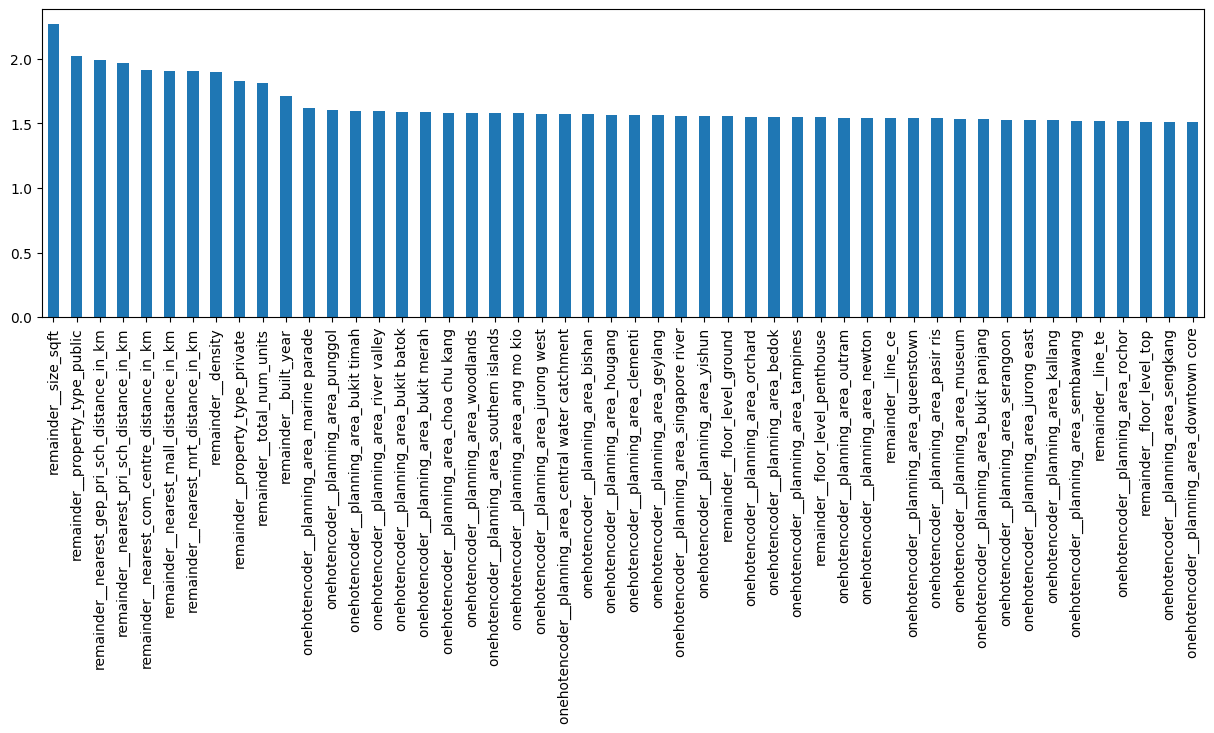

In [13]:
mutual_info.sort_values(ascending=False)[0:50].plot.bar(figsize=(15, 4))

In [14]:
mutual_info[mutual_info < 0.5].index

Index(['onehotencoder__planning_area_mandai', 'onehotencoder__planning_area_paya lebar'], dtype='object')

In [15]:
list(map(lambda x: x.split('__')[1], mutual_info[mutual_info < 0.5].index))

['planning_area_mandai', 'planning_area_paya lebar']